In [1]:
# Data manipulation and processing
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ks_2samp, mannwhitneyu
from scipy.stats import pearsonr

# Geospatial data processing
import geopandas as gpd
from shapely.geometry import LineString, Point

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import FixedLocator
import seaborn as sns


# System operations
import os
import warnings

In [2]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

In [3]:
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'Arial',
    'figure.dpi': 100,
    'font.size': 10
})

In [4]:
root = r'PATH_TO_YOUR_DATA'

In [5]:
od1903 = pd.read_csv(os.path.join(root, 'data', 'od201903.csv'))
od2403 = pd.read_csv(os.path.join(root, 'data', 'od202403.csv'))

In [6]:
def data_prepross(df):
    visit_count = df.loc[:,['visit_grid','home_grid']].groupby('visit_grid', as_index=False).count()
    df = df.loc[df['visit_grid'].isin(np.array(visit_count.loc[visit_count['home_grid']>=3]['visit_grid']))]
    visit_fre = od1903.loc[:,['home_grid','stay_fre']].groupby('home_grid', as_index=False).sum()
    df = df.loc[df['home_grid'].isin(visit_fre.loc[visit_fre['stay_fre']>60]['home_grid'])]
    df = df.loc[df['age'].isin(['a1','a2','a3','a4','a5','a6','a7'])]
    df.loc[(df['home_grid']==df['visit_grid']) & (df['ptype']!=1), 'ptype'] = 1
    df_ses = df.merge(house_price_pop.loc[:,['home_grid','ses','ses2', 'ses3']])
    return df_ses

In [7]:
od_line_geo = pd.read_csv(os.path.join(root, 'data', 'od19_24_fnid_distance.csv'))

In [8]:
house_price_pop = pd.read_csv(os.path.join(root, 'data', 'house_price_pop.csv'))

pcount1903 = pd.read_csv(os.path.join(root, 'data', 'pcount19-24','pcount_1903.csv'))
pcount1903 = pcount1903.groupby(['home_grid', 'age', 'gender', 'is_local'], as_index=False).sum()

pcount2403 = pd.read_csv(os.path.join(root, 'data', 'pcount19-24','pcount_2403.csv'))
pcount2403 = pcount2403.groupby(['home_grid', 'age', 'gender', 'is_local'], as_index=False).sum()

In [9]:
ses = 'ses'

group_list = ['home_grid','age','gender','is_local']

def cal_visit_fre(od_data, time):
    data_new = data_prepross(od_data)
    data_new = data_new.merge(od_line_geo.loc[:,['home_grid', 'visit_grid', 'distance']], on=['home_grid', 'visit_grid'])
    data_visit = data_new.loc[(data_new['ptype']==0)]
    home_fre_df = data_visit.loc[:, group_list+[ses]+['stay_fre']].groupby(group_list+[ses], as_index=False).sum()
    pcount = eval('pcount'+time).loc[eval('pcount'+time)['age'].isin(['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7'])].groupby(group_list, as_index=False).sum()
    home_fre_sum = home_fre_df.merge(pcount, on=group_list)
    home_fre_sum['avg_fre'] = round((home_fre_sum['stay_fre']/home_fre_sum['pcount']), 1)
    return home_fre_sum

def cal_visit_time(od_data, time):
    data_new = data_prepross(od_data)
    data_new = data_new.merge(od_line_geo.loc[:,['home_grid', 'visit_grid', 'distance']], on=['home_grid', 'visit_grid'])
    data_visit = data_new.loc[(data_new['ptype']==0)]
    home_time_df = data_new.loc[data_new[time]>0, group_list+[time, ses]].groupby(group_list+[ses], as_index=False).sum()
    home_visit_time_df = data_visit.loc[data_visit[time]>0, group_list+[time, ses]].groupby(group_list+[ses], as_index=False).sum()
    home_visit_time_df = home_visit_time_df.merge(home_time_df, on=group_list, suffixes=('', '_sum'))
    home_visit_time_df['avg_time'] = home_visit_time_df[time]/home_visit_time_df[time+'_sum']*100
    home_time_mean = home_visit_time_df.loc[:,group_list+['avg_time', ses]]
    return home_time_mean

def cal_visit_distance(od_data, time):
    data_new = data_prepross(od_data)
    data_new = data_new.merge(od_line_geo.loc[:,['home_grid', 'visit_grid', 'distance']], on=['home_grid', 'visit_grid'])
    data_visit = data_new.loc[(data_new['ptype']==0)]
    home_dis_df = data_visit.loc[data_visit[time]>0, group_list+[ses, time, 'distance']]
    home_dis_df['visit_prob'] = home_dis_df.loc[:,group_list+[time]].groupby(group_list)[time].transform(lambda x: x/x.sum())
    home_dis_df['avg_dis'] = home_dis_df['distance'] * home_dis_df['visit_prob']
    home_dis_df_new = home_dis_df.loc[:,group_list+[ses, 'avg_dis']].groupby(group_list+[ses], as_index=False).sum() # weighted average
    home_dis_df_new['avg_dis'] = round(home_dis_df_new['avg_dis']/1000, 3)
    return home_dis_df_new # unit: km

def entropy(time_sequence):
    time_prob = time_sequence/time_sequence.sum()
    entropy = -np.sum(time_prob * np.log(time_prob))
    return entropy

def cal_visit_entropy(od_data):
    data_new = data_prepross(od_data)
    data_new = data_new.merge(od_line_geo.loc[:,['home_grid', 'visit_grid', 'distance']], on=['home_grid', 'visit_grid'])
    data_visit = data_new.loc[(data_new['ptype']==0)]
    data_visit['avg_time'] = data_visit['sum_time']/data_visit['stay_fre']
    entropy_df = data_visit.groupby(group_list+[ses])['avg_time'].apply(lambda x: entropy(np.array(x))).apply(pd.Series).reset_index().rename(columns={0:'entropy'})
    return entropy_df

In [10]:
# visit_fre1903 = cal_visit_fre(od1903, '1903')
# visit_fre1903.to_csv(os.path.join(root, 'data', 'visit_fre1903.csv'), index=False)

# visit_fre2403 = cal_visit_fre(od2403, '2403')
# visit_fre2403.to_csv(os.path.join(root, 'data', 'visit_fre2403.csv'), index=False)

# visit_time1903 = cal_visit_time(od1903, 'sum_time')
# visit_time1903.to_csv(os.path.join(root, 'data', 'visit_time1903.csv'), index=False)

# visit_time2403 = cal_visit_time(od2403, 'sum_time')
# visit_time2403.to_csv(os.path.join(root, 'data', 'visit_time2403.csv'), index=False)

# visit_dis1903 = cal_visit_distance(od1903, 'sum_time')
# visit_dis1903.to_csv(os.path.join(root, 'data', 'visit_dis1903.csv'), index=False)

# visit_dis2403 = cal_visit_distance(od2403, 'sum_time')
# visit_dis2403.to_csv(os.path.join(root, 'data', 'visit_dis2403.csv'), index=False)

# visit_ent1903 = cal_visit_entropy(od1903)
# visit_ent1903.to_csv(os.path.join(root, 'data', 'visit_ent1903.csv'), index=False)

# visit_ent2403 = cal_visit_entropy(od2403)
# visit_ent2403.to_csv(os.path.join(root, 'data', 'visit_ent2403.csv'), index=False)

In [11]:
ses = 'ses'

group_list = ['home_grid']

def cal_visit_fre(od_data, time):
    data_new = data_prepross(od_data)
    data_new = data_new.merge(od_line_geo.loc[:,['home_grid', 'visit_grid', 'distance']], on=['home_grid', 'visit_grid'])
    data_visit = data_new.loc[(data_new['ptype']==0)]
    home_fre_df = data_visit.loc[:, group_list+[ses]+['stay_fre']].groupby(group_list+[ses], as_index=False).sum()
    pcount = eval('pcount'+time).loc[eval('pcount'+time)['age'].isin(['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7'])].groupby(group_list, as_index=False).sum()
    home_fre_sum = home_fre_df.merge(pcount, on=group_list)
    home_fre_sum['avg_fre'] = round((home_fre_sum['stay_fre']/home_fre_sum['pcount']), 1)
    return home_fre_sum

def cal_visit_time(od_data, time):
    data_new = data_prepross(od_data)
    data_new = data_new.merge(od_line_geo.loc[:,['home_grid', 'visit_grid', 'distance']], on=['home_grid', 'visit_grid'])
    data_visit = data_new.loc[(data_new['ptype']==0)]
    home_time_df = data_new.loc[data_new[time]>0, group_list+[time, ses]].groupby(group_list+[ses], as_index=False).sum()
    home_visit_time_df = data_visit.loc[data_visit[time]>0, group_list+[time, ses]].groupby(group_list+[ses], as_index=False).sum()
    home_visit_time_df = home_visit_time_df.merge(home_time_df, on=group_list, suffixes=('', '_sum'))
    home_visit_time_df['avg_time'] = home_visit_time_df[time]/home_visit_time_df[time+'_sum']*100
    home_time_mean = home_visit_time_df.loc[:,group_list+['avg_time', ses]]
    return home_time_mean

def cal_visit_distance(od_data, time):
    data_new = data_prepross(od_data)
    data_new = data_new.merge(od_line_geo.loc[:,['home_grid', 'visit_grid', 'distance']], on=['home_grid', 'visit_grid'])
    data_visit = data_new.loc[(data_new['ptype']==0)]
    home_dis_df = data_visit.loc[data_visit[time]>0, group_list+[ses, time, 'distance']]
    home_dis_df['visit_prob'] = home_dis_df.loc[:,group_list+[time]].groupby(group_list)[time].transform(lambda x: x/x.sum())
    home_dis_df['avg_dis'] = home_dis_df['distance'] * home_dis_df['visit_prob']
    home_dis_df_new = home_dis_df.loc[:,group_list+[ses, 'avg_dis']].groupby(group_list+[ses], as_index=False).sum() # weighted average
    home_dis_df_new['avg_dis'] = round(home_dis_df_new['avg_dis']/1000, 3)
    return home_dis_df_new # unit: km

def entropy(time_sequence):
    time_prob = time_sequence/time_sequence.sum()
    entropy = -np.sum(time_prob * np.log(time_prob))
    return entropy

def cal_visit_entropy(od_data):
    data_new = data_prepross(od_data)
    data_new = data_new.merge(od_line_geo.loc[:,['home_grid', 'visit_grid', 'distance']], on=['home_grid', 'visit_grid'])
    data_visit = data_new.loc[(data_new['ptype']==0)]
    data_visit['avg_time'] = data_visit['sum_time']/data_visit['stay_fre']
    entropy_df = data_visit.groupby(group_list+[ses])['avg_time'].apply(lambda x: entropy(np.array(x))).apply(pd.Series).reset_index().rename(columns={0:'entropy'})
    return entropy_df

In [12]:
# visit_fre1903 = cal_visit_fre(od1903, '1903')
# visit_fre1903.to_csv(os.path.join(root, 'data', 'visit_fre1903_home.csv'), index=False)

# visit_fre2403 = cal_visit_fre(od2403, '2403')
# visit_fre2403.to_csv(os.path.join(root, 'data', 'visit_fre2403_home.csv'), index=False)

# visit_time1903 = cal_visit_time(od1903, 'sum_time')
# visit_time1903.to_csv(os.path.join(root, 'data', 'visit_time1903_home.csv'), index=False)

# visit_time2403 = cal_visit_time(od2403, 'sum_time')
# visit_time2403.to_csv(os.path.join(root, 'data', 'visit_time2403_home.csv'), index=False)

# visit_dis1903 = cal_visit_distance(od1903, 'sum_time')
# visit_dis1903.to_csv(os.path.join(root, 'data', 'visit_dis1903_home.csv'), index=False)

# visit_dis2403 = cal_visit_distance(od2403, 'sum_time')
# visit_dis2403.to_csv(os.path.join(root, 'data', 'visit_dis2403_home.csv'), index=False)

# visit_ent1903 = cal_visit_entropy(od1903)
# visit_ent1903.to_csv(os.path.join(root, 'data', 'visit_ent1903_home.csv'), index=False)

# visit_ent2403 = cal_visit_entropy(od2403)
# visit_ent2403.to_csv(os.path.join(root, 'data', 'visit_ent2403_home.csv'), index=False)

In [13]:
visit_fre1903 = pd.read_csv(os.path.join(root, 'data', 'visit_fre1903.csv'))
visit_fre2403 = pd.read_csv(os.path.join(root, 'data', 'visit_fre2403.csv'))
visit_time1903 = pd.read_csv(os.path.join(root, 'data', 'visit_time1903.csv'))
visit_time2403 = pd.read_csv(os.path.join(root, 'data', 'visit_time2403.csv'))
visit_dis1903 = pd.read_csv(os.path.join(root, 'data', 'visit_dis1903.csv'))
visit_dis2403 = pd.read_csv(os.path.join(root, 'data', 'visit_dis2403.csv'))
visit_ent1903 = pd.read_csv(os.path.join(root, 'data', 'visit_ent1903.csv'))
visit_ent2403 = pd.read_csv(os.path.join(root, 'data', 'visit_ent2403.csv'))

In [14]:
group_list = ['home_grid', 'age', 'gender', 'is_local', 'ses']
visit_fre_change_stat = visit_fre1903.loc[visit_fre1903['pcount']>=5].loc[:,group_list+['pcount','avg_fre']].merge(visit_fre2403.loc[visit_fre2403['pcount']>=5].loc[:,group_list+['pcount','avg_fre']], on=group_list)

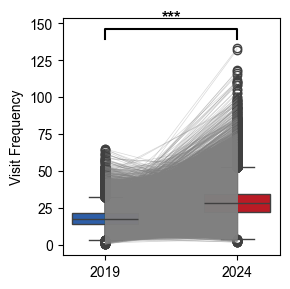

In [15]:

group_list = ['home_grid', 'age', 'gender', 'is_local', 'ses']
visit_fre_change_stat = visit_fre1903.loc[visit_fre1903['pcount']>=5].loc[:,group_list+['pcount','avg_fre']].merge(
    visit_fre2403.loc[visit_fre2403['pcount']>=5].loc[:,group_list+['pcount','avg_fre']], 
    on=group_list, suffixes=('_2019', '_2024'))

plt.figure(figsize=(3, 3))

sns.boxplot(data=visit_fre_change_stat[['avg_fre_2019', 'avg_fre_2024']], 
            palette=['#185abd', '#d5000e'], width=0.5)

for _, row in visit_fre_change_stat.iterrows():
    plt.plot([0, 1], [row['avg_fre_2019'], row['avg_fre_2024']], 
             color='gray', alpha=0.3, linewidth=0.5)

for i, artist in enumerate(plt.gca().artists):
    for j in [4, 5]:
        plt.gca().lines[i*6 + j].set_color('white')
        plt.gca().lines[i*6 + j].set_linewidth(1.5)

w_test = stats.wilcoxon(visit_fre_change_stat['avg_fre_2019'], 
                        visit_fre_change_stat['avg_fre_2024'])
p_value = w_test.pvalue

y_max = visit_fre_change_stat[['avg_fre_2019', 'avg_fre_2024']].max().max() * 1.1
if p_value < 0.05:
    plt.plot([0, 0, 1, 1], [y_max*0.95, y_max, y_max, y_max*0.95], 
             lw=1.5, c='black')
    if p_value < 0.001:
        stars = '***'
    elif p_value < 0.01:
        stars = '**'
    else:
        stars = '*'
    plt.text(0.5, y_max*1.02, stars, ha='center', va='bottom', 
             fontsize=12, fontweight='bold')
else:
    plt.text(0.5, y_max*1.02, 'ns', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

plt.ylabel('Visit Frequency')
plt.xticks([0, 1], ['2019', '2024'])

plt.tight_layout()
plt.show()

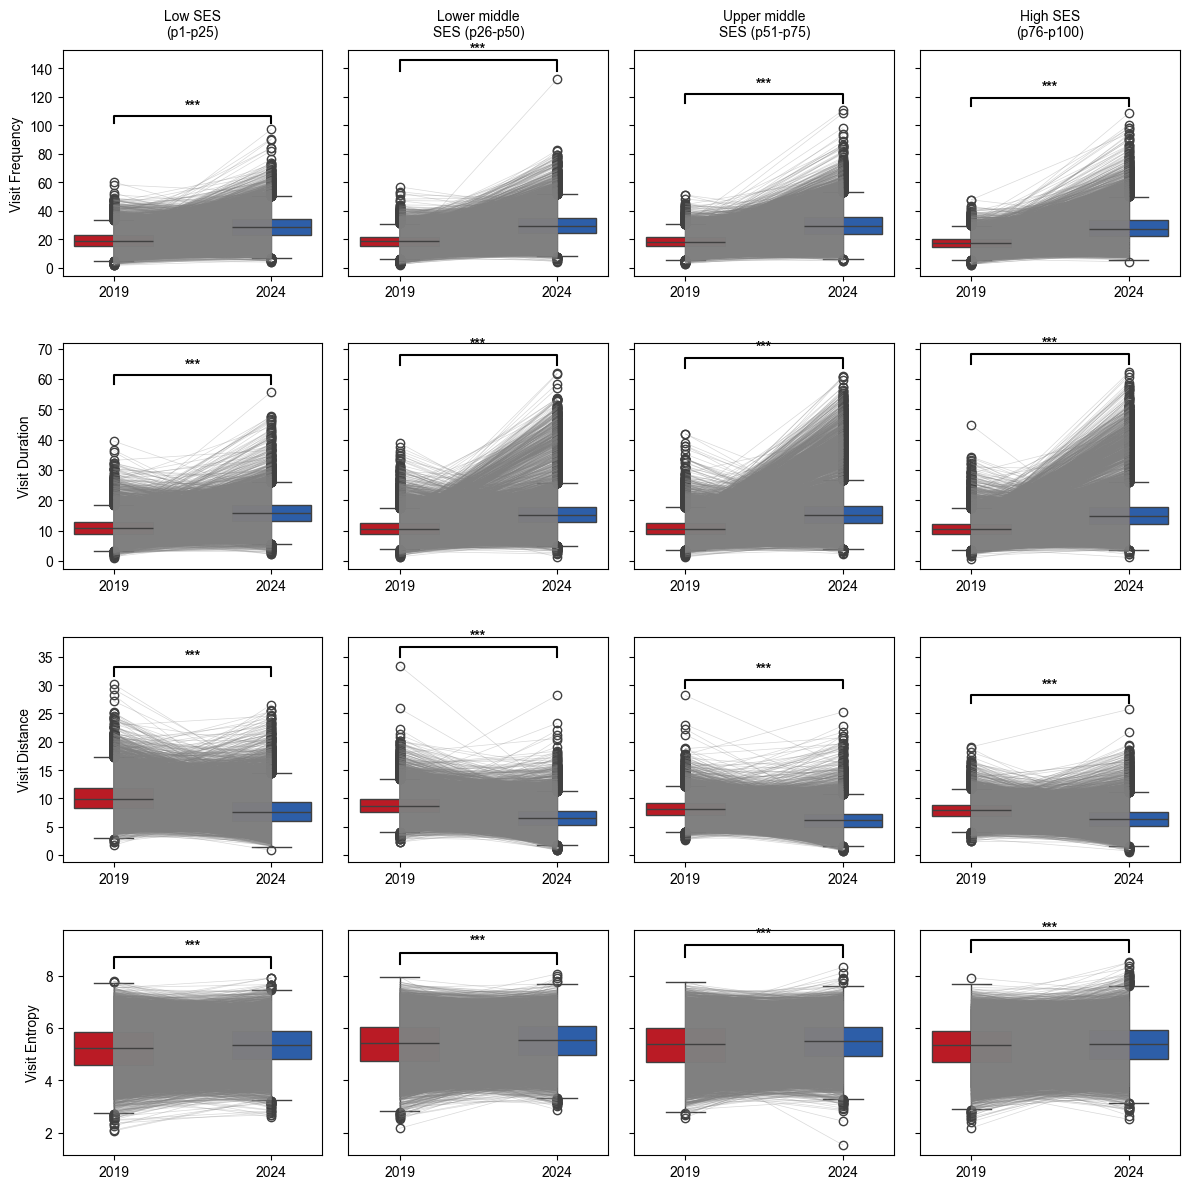

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

COLORS = ['#185abd', '#d5000e'][::-1]
SES_GROUPS = [
    (1, 26, 'Low SES\n(p1-p25)'),
    (26, 51, 'Lower middle\nSES (p26-p50)'),
    (51, 76, 'Upper middle\nSES (p51-p75)'),
    (76, 101, 'High SES\n(p76-p100)')
]

BEHAVIOR_METRICS = [
    ('fre', 'avg_fre', 'Visit Frequency'),
    ('time', 'avg_time', 'Visit Duration'),
    ('dis', 'avg_dis', 'Visit Distance'),
    ('ent', 'entropy', 'Visit Entropy')
]

group_list = ['home_grid', 'age', 'gender', 'is_local', 'ses']

data_2019 = {}
data_2024 = {}

fre_2019 = pd.read_csv(os.path.join(root, 'data', 'visit_fre1903.csv'))
fre_2024 = pd.read_csv(os.path.join(root, 'data', 'visit_fre2403.csv'))

pcount_lim = 10
base_2019 = fre_2019[fre_2019['pcount'] >= pcount_lim][group_list + ['pcount']]
base_2024 = fre_2024[fre_2024['pcount'] >= pcount_lim][group_list + ['pcount']]

for metric, col_name, _ in BEHAVIOR_METRICS:
    if metric == 'fre':
        data_2019[metric] = base_2019.copy()
        data_2024[metric] = base_2024.copy()
        data_2019[metric][col_name] = fre_2019.loc[fre_2019['pcount'] >= pcount_lim, col_name]
        data_2024[metric][col_name] = fre_2024.loc[fre_2024['pcount'] >= pcount_lim, col_name]
    else:
        behavior_2019 = pd.read_csv(os.path.join(root, 'data', f'visit_{metric}1903.csv'))
        behavior_2024 = pd.read_csv(os.path.join(root, 'data', f'visit_{metric}2403.csv'))
        
        data_2019[metric] = behavior_2019.merge(
            base_2019, 
            on=group_list, 
            how='inner' 
        )
        data_2024[metric] = behavior_2024.merge(
            base_2024, 
            on=group_list, 
            how='inner'
        )

fig, axes = plt.subplots(len(BEHAVIOR_METRICS), len(SES_GROUPS), 
                         figsize=(12, 12), sharey='row')

for row, (metric, col_name, ylabel) in enumerate(BEHAVIOR_METRICS):
    df_2019 = data_2019[metric]
    df_2024 = data_2024[metric]
    
    for col, (start, end, title) in enumerate(SES_GROUPS):
        ax = axes[row, col]
        
        if start == 1 and end == 101:  # Total group
            subset_2019 = df_2019
            subset_2024 = df_2024
        else:
            subset_2019 = df_2019[df_2019['ses'].isin(range(start, end))]
            subset_2024 = df_2024[df_2024['ses'].isin(range(start, end))]

        paired_data = subset_2019[group_list + [col_name]].merge(
            subset_2024[group_list + [col_name]], 
            on=group_list, 
            suffixes=('_2019', '_2024'))
        
        if len(paired_data) == 0:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
            ax.set_title(title if row == 0 else '', fontsize=10)
            continue
        
        sns.boxplot(data=paired_data[[f'{col_name}_2019', f'{col_name}_2024']], 
                   palette=COLORS, width=0.5, ax=ax)
        
        for _, row_data in paired_data.iterrows():
            ax.plot([0, 1], [row_data[f'{col_name}_2019'], row_data[f'{col_name}_2024']], 
                    color='gray', alpha=0.3, linewidth=0.5)
        
        for i, artist in enumerate(ax.artists):
            for j in [4, 5]:
                ax.lines[i*6 + j].set_color('white')
                ax.lines[i*6 + j].set_linewidth(1.5)
        
        try:
            w_test = stats.wilcoxon(paired_data[f'{col_name}_2019'], 
                                   paired_data[f'{col_name}_2024'])
            p_value = w_test.pvalue
        except:
            p_value = 1.0 
        
        y_max = paired_data[[f'{col_name}_2019', f'{col_name}_2024']].max().max() * 1.1
        if p_value < 0.05:
            ax.plot([0, 0, 1, 1], [y_max*0.95, y_max, y_max, y_max*0.95], 
                    lw=1.5, c='black')
            if p_value < 0.001:
                stars = '***'
            elif p_value < 0.01:
                stars = '**'
            else:
                stars = '*'
            ax.text(0.5, y_max*1.02, stars, 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
        else:
            ax.text(0.5, y_max*1.02, 'ns', 
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        if row == 0:
            ax.set_title(title, fontsize=10, pad=10)
        if col == 0:
            ax.set_ylabel(ylabel, fontsize=10)
        else:
            ax.set_ylabel('')
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['2019', '2024'])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.1)
# plt.savefig('.png', dpi=500, bbox_inches='tight')
plt.show()

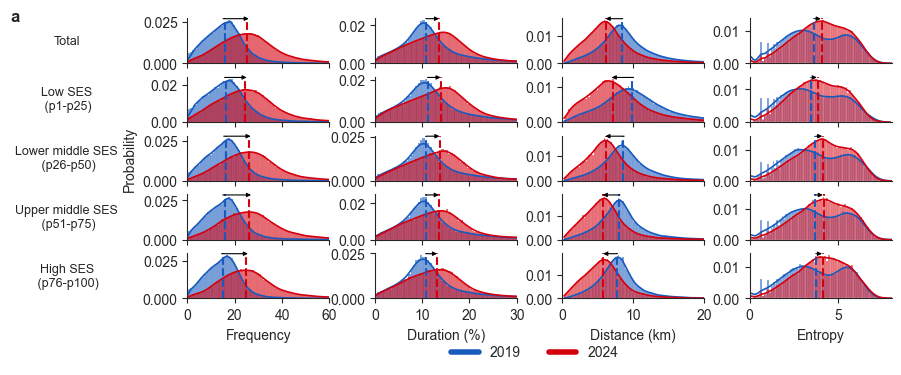

In [17]:
sns.set_style('ticks')

COLORS = ['#185abd', '#d5000e'][::-1]
data_list = [
    ('visit_fre', 'avg_fre', 'Frequency', 1),    
    ('visit_time', 'avg_time', 'Duration (%)', 0.5),
    ('visit_dis', 'avg_dis', 'Distance (km)', 0.2),
    ('visit_ent', 'entropy', 'Entropy', 0.1),
]

SES_GROUPS = [
    (1, 101, 'Total'),
    (1, 26, 'Low SES\n (p1-p25)'),
    (26, 51, 'Lower middle SES\n (p26-p50)'),
    (51, 76, 'Upper middle SES\n (p51-p75)'),
    (76, 101, 'High SES\n (p76-p100)')
]

fig, axes = plt.subplots(len(SES_GROUPS), len(data_list), figsize=(9.3, 3.5))

for i, (data_name, x_col, x_label, bin_width) in enumerate(data_list):
    combined_data = pd.concat([
        globals()[f'{data_name}1903'].assign(year='2019'),
        globals()[f'{data_name}2403'].assign(year='2024'),
    ])

    for j, (ses_start, ses_end, ses_label) in enumerate(SES_GROUPS):
        group_data = combined_data[combined_data['ses'].isin(range(ses_start, ses_end))]

        sns.histplot(data=group_data, x=x_col, hue="year", binwidth=bin_width, stat='probability', line_kws={'linewidth': 1.2},
                     palette=COLORS, alpha=0.6, kde=True, hue_order=['2024', '2019'], ax=axes[j, i])

        m_value_list = []
        for year in ['2019', '2024']:
            m_value = group_data[group_data['year'] == year][x_col].median()
            m_value_list.append(m_value)
            color = COLORS[0] if year == '2024' else COLORS[1]
            axes[j, i].axvline(m_value, color=color, linestyle='--', linewidth=1.5)
        
        y_min, y_max = axes[j, i].get_ylim()
        y_percent = y_min + 0.99 * (y_max - y_min)
        extension = 0.2 * (m_value_list[1] - m_value_list[0])
        axes[j, i].annotate('', xy=(m_value_list[1] + extension, y_percent),
                            xytext=(m_value_list[0] - extension, y_percent),
                           arrowprops=dict(arrowstyle="-|>", color="black", lw=0.8, mutation_scale=6),
                           ha='center', va='center')
    axes[-1, i].set_xlabel(x_label)

x_limits = [(0, 60), (0, 30), (0, 20), (0, 8)]

for i in range(len(SES_GROUPS)):
    for j in range(len(data_list)):
        axes[i, j].set_xlim(x_limits[j])


for i in range(len(SES_GROUPS)):
    for j in range(len(data_list)):
        if i != len(SES_GROUPS)-1:
            axes[i, j].set_xticklabels([])
            axes[i, j].set_xlabel('')
        if j == 0 and i == 2:
            axes[i, j].set_ylabel('Probability')
        else:
            axes[i, j].set_ylabel('')

for j, (_, _, ses_label) in enumerate(SES_GROUPS):
    axes[j, 0].text(-0.85, 0.5, ses_label, transform=axes[j, 0].transAxes,
                   fontsize=9, va='center', ha='center')

for i in range(len(SES_GROUPS)):
    for j in range(len(data_list)):
        if axes[i, j].get_legend() is not None:
            axes[i, j].get_legend().remove()

axes[0, 0].text(-1.25, 1.2, 'a', transform=axes[0, 0].transAxes, fontsize=12, fontweight='bold', va='top', ha='left')

legend_elements = [
    Line2D([0], [0], color=COLORS[1], lw=4, label='2019'),
    Line2D([0], [0], color=COLORS[0], lw=4, label='2024'),
]

fig.legend(handles=legend_elements,
           loc='lower center',
           bbox_to_anchor=(0.6, -0.08),
           ncol=2,
           frameon=False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.32, hspace=0.3, bottom=0.13)
sns.despine()
# plt.savefig('fig2a.pdf', dpi=500, bbox_inches='tight')
plt.show()

In [18]:
group_list = ['home_grid', 'age', 'gender', 'is_local']
ses = 'ses'

data_list = [
    ('visit_fre', 'avg_fre', 'Frequency', 1),
    ('visit_time', 'avg_time', 'Duration', 0.5),
    ('visit_dis', 'avg_dis', 'Distance', 0.2),
    ('visit_ent', 'entropy', 'Entropy', 0.1),
]

full_combined_data = pd.DataFrame()

for data_name, x_col, x_label, bin_width in data_list:
    if f'{data_name}1903' not in globals() or f'{data_name}2403' not in globals():
        continue
    
    try:
        temp_data = pd.concat([
            globals()[f'{data_name}1903'].assign(year='2019'),
            globals()[f'{data_name}2403'].assign(year='2024')
        ])
        
        keep_columns = group_list + [ses, 'year', x_col]
        temp_data = temp_data[[c for c in keep_columns if c in temp_data.columns]]
        temp_data = temp_data.rename(columns={x_col: 'value'})
        temp_data['metric'] = x_label
        full_combined_data = pd.concat([full_combined_data, temp_data])
    except Exception:
        continue

if len(full_combined_data) == 0:
    raise ValueError("No data was combined.")

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0:
        return np.nan
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std if pooled_std != 0 else np.nan

def cliffs_delta(x, y):
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0:
        return np.nan
    u = mannwhitneyu(x, y, alternative='two-sided')[0]
    return (2 * u) / (nx * ny) - 1

def analyze_data(combined_data):
    ses_groups = [
        (1, 101, 'Total'),
        (1, 26, 'Low SES'),
        (26, 51, 'Lower middle SES'),
        (51, 76, 'Upper middle SES'),
        (76, 101, 'High SES')
    ]
    
    results = []
    
    for metric_name in combined_data['metric'].unique():
        metric_data = combined_data[combined_data['metric'] == metric_name]
        
        for ses_start, ses_end, ses_name in ses_groups:
            group_data = metric_data[metric_data['ses'].isin(range(ses_start, ses_end))]
            
            if len(group_data[group_data['year'] == '2019']) == 0 or len(group_data[group_data['year'] == '2024']) == 0:
                continue
                
            data_2019 = group_data[group_data['year'] == '2019']['value']
            data_2024 = group_data[group_data['year'] == '2024']['value']
            
            try:
                mean_2019, mean_2024 = np.mean(data_2019), np.mean(data_2024)
                mean_pct_change = (mean_2024 - mean_2019) / mean_2019 * 100 if mean_2019 != 0 else np.nan
                ks_p = ks_2samp(data_2019, data_2024)[1]
                mwu_p = mannwhitneyu(data_2019, data_2024, alternative='two-sided')[1]
                d = cohens_d(data_2024, data_2019)
                delta = cliffs_delta(data_2024, data_2019)
                
                results.append({
                    'Metric': metric_name,
                    'SES Group': ses_name,
                    'Mean Growth %': mean_pct_change,
                    'KS p-value': ks_p,
                    'MWU p-value': mwu_p,
                    "Cohen's d": d,
                    "Cliff's delta": delta
                })
            except Exception as e:
                print(f"Error analyzing {metric_name} for {ses_name}: {str(e)}")
                continue
    
    return pd.DataFrame(results)

results_df = analyze_data(full_combined_data)

if not results_df.empty:
    results_df['Significant (KS)'] = results_df['KS p-value'] < 0.05
    results_df['Significant (MWU)'] = results_df['MWU p-value'] < 0.05
    results_df['Cohen Effect Size'] = results_df["Cohen's d"].abs().apply(
        lambda x: 'Small' if x < 0.5 else 'Medium' if x < 0.8 else 'Large')
    results_df['Cliff Effect Size'] = results_df["Cliff's delta"].abs().apply(
        lambda x: 'Small' if x < 0.33 else 'Medium' if x < 0.474 else 'Large')
    
    print("\nStatistical Test Results:")
    print("="*150)
    print(results_df.to_string(index=False))
    print("="*150)
    # results_df.to_csv('mobility_sig.csv',index=False)
else:
    print("No results were generated.")


Statistical Test Results:
   Metric        SES Group  Mean Growth %    KS p-value   MWU p-value  Cohen's d  Cliff's delta  Significant (KS)  Significant (MWU) Cohen Effect Size Cliff Effect Size
Frequency            Total      65.338134  0.000000e+00  0.000000e+00   0.852406       0.508159              True               True             Large             Large
Frequency          Low SES      53.195725  0.000000e+00  0.000000e+00   0.700471       0.426490              True               True            Medium            Medium
Frequency Lower middle SES      65.443871  0.000000e+00  0.000000e+00   0.884869       0.524520              True               True             Large             Large
Frequency Upper middle SES      73.524789  0.000000e+00  0.000000e+00   0.936565       0.552279              True               True             Large             Large
Frequency         High SES      73.170872  0.000000e+00  0.000000e+00   0.940952       0.553046              True               

C:\Users\DELL\AppData\Local\Temp\ipykernel_40760\3993633187.py:63: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = group_data.groupby('ses_group', observed=True).apply(get_regression_stats, x=x, y=y).reset_index()
C:\Users\DELL\AppData\Local\Temp\ipykernel_40760\3993633187.py:63: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = group_data.groupby('ses_group', observed=True).apply(get_regression_stats, x=x, y=y

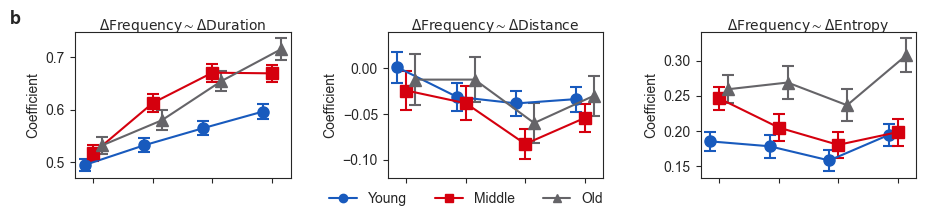

In [19]:
group_list = ['home_grid','age','gender','is_local']
ses = 'ses'
def cal_visit_diff(data19, data24, kind):
    visit_diff = data19.loc[:, group_list + [ses, kind]].merge(data24.loc[:, group_list + [ses, kind]], on=group_list + [ses], suffixes=('19', '24'))
    visit_diff[kind + '_diff'] = visit_diff[kind + '24'] - visit_diff[kind + '19']
    return visit_diff

visit_fre_diff = cal_visit_diff(visit_fre1903, visit_fre2403, 'avg_fre')
visit_time_diff = cal_visit_diff(visit_time1903, visit_time2403, 'avg_time')
visit_dis_diff = cal_visit_diff(visit_dis1903, visit_dis2403, 'avg_dis')
visit_ent_diff = cal_visit_diff(visit_ent1903, visit_ent2403, 'entropy')

visit_diff = visit_fre_diff.loc[:, group_list + [ses, 'avg_fre_diff']].merge(visit_time_diff.loc[:, group_list + [ses, 'avg_time_diff']], on=group_list + [ses]).merge(visit_dis_diff.loc[:, group_list + [ses, 'avg_dis_diff']], on=group_list + [ses]).merge(visit_ent_diff.loc[:, group_list + [ses, 'entropy_diff']],  on=group_list + [ses])

ses_bins = [1, 26, 51, 76, 101]
ses_labels = ['low ses', 'lower middle ses', 'upper middle ses', 'high ses']
visit_diff['ses_group'] = pd.cut(visit_diff['ses'], bins=ses_bins, labels=ses_labels, right=False, include_lowest=False)

visit_diff_young = visit_diff.loc[visit_diff['age'].isin(['a2', 'a3'])]
visit_diff_mid = visit_diff.loc[visit_diff['age'].isin(['a4', 'a5'])]
visit_diff_old = visit_diff.loc[visit_diff['age'].isin(['a6', 'a7'])]

scaler = StandardScaler()
visit_diff[['avg_fre_diff', 'avg_time_diff', 'avg_dis_diff', 'entropy_diff']] = \
    scaler.fit_transform(visit_diff[['avg_fre_diff', 'avg_time_diff', 'avg_dis_diff', 'entropy_diff']])

def get_regression_stats(group, x, y):
    if len(group) < 5:
        return pd.Series({
            'Slope': np.nan,
            'CI_lower': np.nan,
            'CI_upper': np.nan,
            'P_value': np.nan
        })
    
    X = sm.add_constant(group[x])
    model = sm.OLS(group[y], X).fit()
    conf_int = model.conf_int(alpha=0.05).iloc[1]
    return pd.Series({
        'Slope': model.params.iloc[1],
        'CI_lower': conf_int[0],
        'CI_upper': conf_int[1],
        'P_value': model.pvalues.iloc[1]
    })

fig, axes = plt.subplots(1, 3, figsize=(9.3, 2))
plt.subplots_adjust(wspace=0.35, bottom=0.25)

palette = {'Young': '#185abd', 'Middle': '#d5000e', 'Old': '#656468'}
markers = {'Young': 'o', 'Middle': 's', 'Old': '^'}
offsets = {'Young': -0.15, 'Middle': 0, 'Old': 0.15}

for i, (x, y) in enumerate([('avg_fre_diff', 'avg_time_diff'), 
                           ('avg_fre_diff', 'avg_dis_diff'),
                           ('avg_fre_diff', 'entropy_diff')]):
    
    ax = axes[i]
    results = []
    
    for age_label, age_group in zip(['Young', 'Middle', 'Old'], 
                                   [['a1','a2','a3'], ['a4','a5'], ['a6','a7']]):
        group_data = visit_diff[visit_diff['age'].isin(age_group)]
        res = group_data.groupby('ses_group', observed=True).apply(get_regression_stats, x=x, y=y).reset_index()
        res['age_group'] = age_label
        results.append(res)
    
    combined = pd.concat(results).dropna()
    
    for age_group in ['Young', 'Middle', 'Old']:
        group_data = combined[combined['age_group'] == age_group]
        x_pos = np.arange(len(group_data)) 
        
        ax.errorbar(x=x_pos + offsets[age_group],
                   y=group_data['Slope'],
                   yerr=[group_data['Slope'] - group_data['CI_lower'], 
                         group_data['CI_upper'] - group_data['Slope']],
                   fmt=markers[age_group],
                   color=palette[age_group],
                   ecolor=palette[age_group],
                   elinewidth=1.5,
                   capsize=4,
                   capthick=1.5,
                   label=age_group if i == 0 else "",
                   ms=8,
                   linestyle='-',
                   linewidth=1.5)
        
    ax.set_xticks(range(4))
    ax.set_xticklabels([],
                      fontsize=10, rotation=45)
    ax.set_xlabel('', fontsize=10)
    ax.set_ylabel('Coefficient', fontsize=10)
    
axes[0].text(0.5,1.1, r'$\mathregular{\Delta\mathrm{Frequency} \sim \Delta\mathrm{Duration}}$', transform=axes[0].transAxes, fontsize=10, va='top', ha='center')
axes[1].text(0.5,1.1, r'$\mathregular{\Delta\mathrm{Frequency} \sim \Delta\mathrm{Distance}}$', transform=axes[1].transAxes, fontsize=10, va='top', ha='center')
axes[2].text(0.5,1.1, r'$\mathregular{\Delta\mathrm{Frequency} \sim \Delta\mathrm{Entropy}}$', transform=axes[2].transAxes, fontsize=10, va='top', ha='center')

axes[1].set_ylim([-0.12,0.04])

axes[0].text(-0.3, 1.15, 'b', transform=axes[0].transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
    
handles = [plt.Line2D([], [], marker=markers[g], color=palette[g], 
                      linestyle='-', label=g) for g in ['Young', 'Middle', 'Old']]
fig.legend(handles=handles, loc='lower center', 
           bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.45, bottom=0.1)
# plt.savefig('fig2b.pdf', dpi=500, bbox_inches='tight')
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_40760\2327430726.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = group_data.groupby('ses_group', observed=True).apply(get_regression_stats, x=x, y=y).reset_index()
C:\Users\DELL\AppData\Local\Temp\ipykernel_40760\2327430726.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = group_data.groupby('ses_group', observed=True).apply(get_regression_stats, x=x, y=y

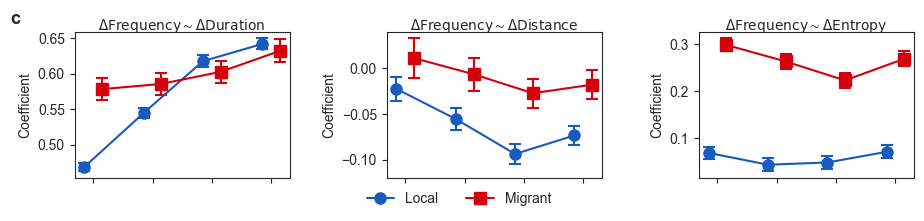

In [20]:
group_list = ['home_grid','age','gender','is_local']
ses = 'ses'
def cal_visit_diff(data19, data24, kind):
    visit_diff = data19.loc[:, group_list + [ses, kind]].merge(
        data24.loc[:, group_list + [ses, kind]], 
        on=group_list + [ses], 
        suffixes=('19', '24')
    )
    visit_diff[kind + '_diff'] = visit_diff[kind + '24'] - visit_diff[kind + '19']
    return visit_diff

visit_fre_diff = cal_visit_diff(visit_fre1903, visit_fre2403, 'avg_fre')
visit_time_diff = cal_visit_diff(visit_time1903, visit_time2403, 'avg_time')
visit_dis_diff = cal_visit_diff(visit_dis1903, visit_dis2403, 'avg_dis')
visit_ent_diff = cal_visit_diff(visit_ent1903, visit_ent2403, 'entropy')

visit_diff = visit_fre_diff.loc[:, group_list + [ses, 'avg_fre_diff']]\
    .merge(visit_time_diff.loc[:, group_list + [ses, 'avg_time_diff']])\
    .merge(visit_dis_diff.loc[:, group_list + [ses, 'avg_dis_diff']])\
    .merge(visit_ent_diff.loc[:, group_list + [ses, 'entropy_diff']])

ses_bins = [1, 26, 51, 76, 101]
ses_labels = ['low ses', 'lower middle ses', 'upper middle ses', 'high ses']
visit_diff['ses_group'] = pd.cut(
    visit_diff['ses'], 
    bins=ses_bins, 
    labels=ses_labels, 
    right=False
)

scaler = StandardScaler()
visit_diff[['avg_fre_diff', 'avg_time_diff', 'avg_dis_diff', 'entropy_diff']] = \
    scaler.fit_transform(visit_diff[['avg_fre_diff', 'avg_time_diff', 'avg_dis_diff', 'entropy_diff']])

local_categories = ['Y', 'N']
local_labels = ['Local', 'Migrant']

def get_regression_stats(group, x, y):
    if len(group) < 10: 
        return pd.Series({
            'Slope': np.nan,
            'CI_lower': np.nan,
            'CI_upper': np.nan,
            'P_value': np.nan
        })
    
    X = sm.add_constant(group[x])
    model = sm.OLS(group[y], X).fit()
    conf_int = model.conf_int(alpha=0.05).iloc[1]
    return pd.Series({
        'Slope': model.params.iloc[1],
        'CI_lower': conf_int[0],
        'CI_upper': conf_int[1],
        'P_value': model.pvalues.iloc[1]
    })

fig, axes = plt.subplots(1, 3, figsize=(9.4, 2))
plt.subplots_adjust(wspace=0.05, bottom=0.25)
palette = {'Local': '#185abd', 'Migrant': '#d5000e'}
markers = {'Local': 'o', 'Migrant': 's'}
offsets = {'Local': -0.15, 'Migrant': 0.15}

for i, (x, y) in enumerate([('avg_fre_diff', 'avg_time_diff'), 
                           ('avg_fre_diff', 'avg_dis_diff'),
                           ('avg_fre_diff', 'entropy_diff')]):
    
    ax = axes[i]
    results = []
    
    for local_code, local_label in zip(local_categories, local_labels):
        group_data = visit_diff[visit_diff['is_local'] == local_code]
        res = group_data.groupby('ses_group', observed=True).apply(get_regression_stats, x=x, y=y).reset_index()
        res['local_group'] = local_label
        results.append(res)
    
    combined = pd.concat(results).dropna()
    
    for local_group in local_labels:
        group_data = combined[combined['local_group'] == local_group]
        x_pos = np.arange(len(group_data))
        
        ax.errorbar(
            x=x_pos + offsets[local_group],
            y=group_data['Slope'],
            yerr=[group_data['Slope'] - group_data['CI_lower'], 
                  group_data['CI_upper'] - group_data['Slope']],
            fmt=markers[local_group],
            color=palette[local_group],
            ecolor=palette[local_group],
            elinewidth=1.5,
            capsize=4,
            capthick=1.5,
            label=local_group if i == 0 else "",
            ms=8,
            linestyle='-',
            linewidth=1.5
        )
        
    
    ax.set_xticks(range(4))
    # ax.set_xticklabels([
    #     'Low SES\n(p1-p25)', 'Lower middle SES\n(p26-p50)',
    #     'Upper middle SES\n(p51-p75)', 'High SES\n(p76-p100)'
    # ], rotation=45, ha='center')
    ax.set_xticklabels([],
                      fontsize=10, rotation=45)
    ax.set_xlabel('', fontsize=10)
    ax.set_ylabel('Coefficient', fontsize=10)

axes[0].text(0.5,1.1, r'$\mathregular{\Delta\mathrm{Frequency} \sim \Delta\mathrm{Duration}}$', transform=axes[0].transAxes, fontsize=10, va='top', ha='center')
axes[1].text(0.5,1.1, r'$\mathregular{\Delta\mathrm{Frequency} \sim \Delta\mathrm{Distance}}$', transform=axes[1].transAxes, fontsize=10, va='top', ha='center')
axes[2].text(0.5,1.1, r'$\mathregular{\Delta\mathrm{Frequency} \sim \Delta\mathrm{Entropy}}$', transform=axes[2].transAxes, fontsize=10, va='top', ha='center')

axes[1].set_ylim([-0.12,0.04])

axes[0].text(-0.3, 1.15, 'c', transform=axes[0].transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

handles = [
    plt.Line2D([], [], marker=markers[g], color=palette[g],
               linestyle='-', label=g, markersize=8)
    for g in local_labels
]
fig.legend(
    handles=handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    frameon=False,
    title=''
)

plt.tight_layout()
plt.subplots_adjust(wspace=0.45, bottom=0.1)
# plt.savefig('fig2c.pdf', dpi=500, bbox_inches='tight')
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_40760\1462511172.py:81: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = group_data.groupby('ses_group', observed=True).apply(get_regression_stats, x=x, y=y).reset_index()
C:\Users\DELL\AppData\Local\Temp\ipykernel_40760\1462511172.py:81: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = group_data.groupby('ses_group', observed=True).apply(get_regression_stats, x=x, y=y

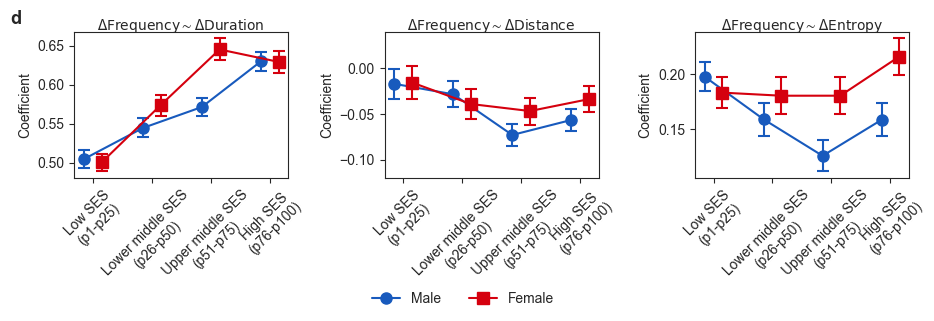

In [21]:
# Define gender groups
gender_categories = [1, 2]  # Male and Female
gender_labels = ['Male', 'Female']

# Calculate visit differences (same as before)
def cal_visit_diff(data19, data24, kind):
    visit_diff = data19.loc[:, group_list + [ses, kind]].merge(
        data24.loc[:, group_list + [ses, kind]], 
        on=group_list + [ses], 
        suffixes=('19', '24')
    )
    visit_diff[kind + '_diff'] = visit_diff[kind + '24'] - visit_diff[kind + '19']
    return visit_diff

visit_fre_diff = cal_visit_diff(visit_fre1903, visit_fre2403, 'avg_fre')
visit_time_diff = cal_visit_diff(visit_time1903, visit_time2403, 'avg_time')
visit_dis_diff = cal_visit_diff(visit_dis1903, visit_dis2403, 'avg_dis')
visit_ent_diff = cal_visit_diff(visit_ent1903, visit_ent2403, 'entropy')

# Merge all differences
visit_diff = visit_fre_diff.loc[:, group_list + [ses, 'avg_fre_diff']]\
    .merge(visit_time_diff.loc[:, group_list + [ses, 'avg_time_diff']])\
    .merge(visit_dis_diff.loc[:, group_list + [ses, 'avg_dis_diff']])\
    .merge(visit_ent_diff.loc[:, group_list + [ses, 'entropy_diff']])

# Create SES groups
ses_bins = [1, 26, 51, 76, 101]
ses_labels = ['low ses', 'lower middle ses', 'upper middle ses', 'high ses']
visit_diff['ses_group'] = pd.cut(
    visit_diff['ses'], 
    bins=ses_bins, 
    labels=ses_labels, 
    right=False
)

# Standardize the differences
scaler = StandardScaler()
visit_diff[['avg_fre_diff', 'avg_time_diff', 'avg_dis_diff', 'entropy_diff']] = \
    scaler.fit_transform(visit_diff[['avg_fre_diff', 'avg_time_diff', 'avg_dis_diff', 'entropy_diff']])

# Regression function (same as before)
def get_regression_stats(group, x, y):
    if len(group) < 10: 
        return pd.Series({
            'Slope': np.nan,
            'CI_lower': np.nan,
            'CI_upper': np.nan,
            'P_value': np.nan
        })
    
    X = sm.add_constant(group[x])
    model = sm.OLS(group[y], X).fit()
    conf_int = model.conf_int(alpha=0.05).iloc[1]
    return pd.Series({
        'Slope': model.params.iloc[1],
        'CI_lower': conf_int[0],
        'CI_upper': conf_int[1],
        'P_value': model.pvalues.iloc[1]
    })

# Create figure (maintaining all original parameters)
fig, axes = plt.subplots(1, 3, figsize=(9.5, 2))
plt.subplots_adjust(wspace=0.05, bottom=0.25)

# Define visual properties (using same colors but for gender)
palette = {'Male': '#185abd', 'Female': '#d5000e'}  # Blue for Male, Red for Female
markers = {'Male': 'o', 'Female': 's'}
offsets = {'Male': -0.15, 'Female': 0.15}

# Plot each relationship (maintaining exact same style)
for i, (x, y) in enumerate([('avg_fre_diff', 'avg_time_diff'), 
                           ('avg_fre_diff', 'avg_dis_diff'),
                           ('avg_fre_diff', 'entropy_diff')]):
    
    ax = axes[i]
    results = []
    
    # Group by gender instead of local status
    for gender_code, gender_label in zip(gender_categories, gender_labels):
        group_data = visit_diff[visit_diff['gender'] == gender_code]
        res = group_data.groupby('ses_group', observed=True).apply(get_regression_stats, x=x, y=y).reset_index()
        res['gender_group'] = gender_label
        results.append(res)
    
    combined = pd.concat(results).dropna()
    
    for gender_group in gender_labels:
        group_data = combined[combined['gender_group'] == gender_group]
        x_pos = np.arange(len(group_data))
        
        ax.errorbar(
            x=x_pos + offsets[gender_group],
            y=group_data['Slope'],
            yerr=[group_data['Slope'] - group_data['CI_lower'], 
                  group_data['CI_upper'] - group_data['Slope']],
            fmt=markers[gender_group],
            color=palette[gender_group],
            ecolor=palette[gender_group],
            elinewidth=1.5,
            capsize=4,
            capthick=1.5,
            label=gender_group if i == 0 else "",
            ms=8,
            linestyle='-',
            linewidth=1.5
        )
    
    ax.set_xticks(range(4))
    ax.set_xticklabels([
        'Low SES\n(p1-p25)', 'Lower middle SES\n(p26-p50)',
        'Upper middle SES\n(p51-p75)', 'High SES\n(p76-p100)'
    ], rotation=45, ha='center')
    ax.set_xlabel('', fontsize=10)
    ax.set_ylabel('Coefficient', fontsize=10)

# Add titles (same as original)
axes[0].text(0.5,1.1, r'$\mathregular{\Delta\mathrm{Frequency} \sim \Delta\mathrm{Duration}}$', 
             transform=axes[0].transAxes, fontsize=10, va='top', ha='center')
axes[1].text(0.5,1.1, r'$\mathregular{\Delta\mathrm{Frequency} \sim \Delta\mathrm{Distance}}$', 
             transform=axes[1].transAxes, fontsize=10, va='top', ha='center')
axes[2].text(0.5,1.1, r'$\mathregular{\Delta\mathrm{Frequency} \sim \Delta\mathrm{Entropy}}$', 
             transform=axes[2].transAxes, fontsize=10, va='top', ha='center')

# Maintain same y-axis limits
axes[1].set_ylim([-0.12,0.04])

# Create legend (same style)
handles = [
    plt.Line2D([], [], marker=markers[g], color=palette[g],
               linestyle='-', label=g, markersize=8)
    for g in gender_labels
]
fig.legend(
    handles=handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=2,
    frameon=False,
    title=''
)
axes[0].text(-0.3, 1.15, 'd', transform=axes[0].transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
plt.tight_layout()
plt.subplots_adjust(wspace=0.45, bottom=0.1)
# plt.savefig('fig2d.pdf', dpi=500, bbox_inches='tight')
plt.show()

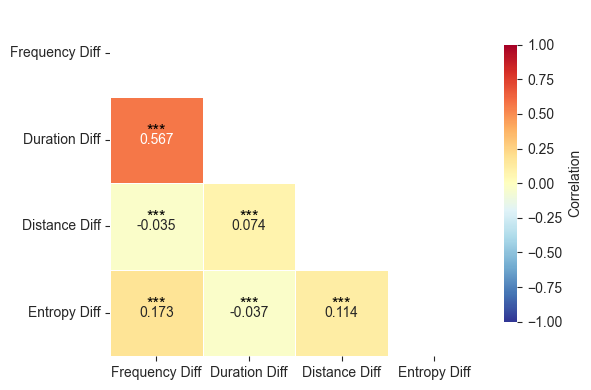

In [22]:
diff_columns = ['avg_fre_diff', 'avg_time_diff', 'avg_dis_diff', 'entropy_diff']
data = visit_diff[diff_columns]

corr_matrix = pd.DataFrame(np.zeros((len(diff_columns), len(diff_columns))), 
                          columns=diff_columns, index=diff_columns)
p_matrix = pd.DataFrame(np.zeros((len(diff_columns), len(diff_columns))), 
                       columns=diff_columns, index=diff_columns)

for i in range(len(diff_columns)):
    for j in range(len(diff_columns)):
        corr, p_val = pearsonr(data[diff_columns[i]], data[diff_columns[j]])
        corr_matrix.iloc[i, j] = corr
        p_matrix.iloc[i, j] = p_val

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, 
    mask=mask,
    annot=True, 
    fmt=".3f", 
    cmap='RdYlBu_r',
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation"} 
)

for i in range(len(diff_columns)):
    for j in range(i): 
        p_val = p_matrix.iloc[i, j]
        if p_val < 0.001:
            marker = "***"
        elif p_val < 0.01:
            marker = "**"
        elif p_val < 0.05:
            marker = "*"
        else:
            marker = ""
        plt.text(j + 0.5, i + 0.4, marker, 
                ha='center', va='center', color='black', fontsize=12)

new_labels = ['Frequency Diff', 'Duration Diff', 'Distance Diff', 'Entropy Diff']
plt.xticks(np.arange(len(diff_columns)) + 0.5, new_labels)
plt.yticks(np.arange(len(diff_columns)) + 0.5, new_labels)

plt.tight_layout()
plt.show()

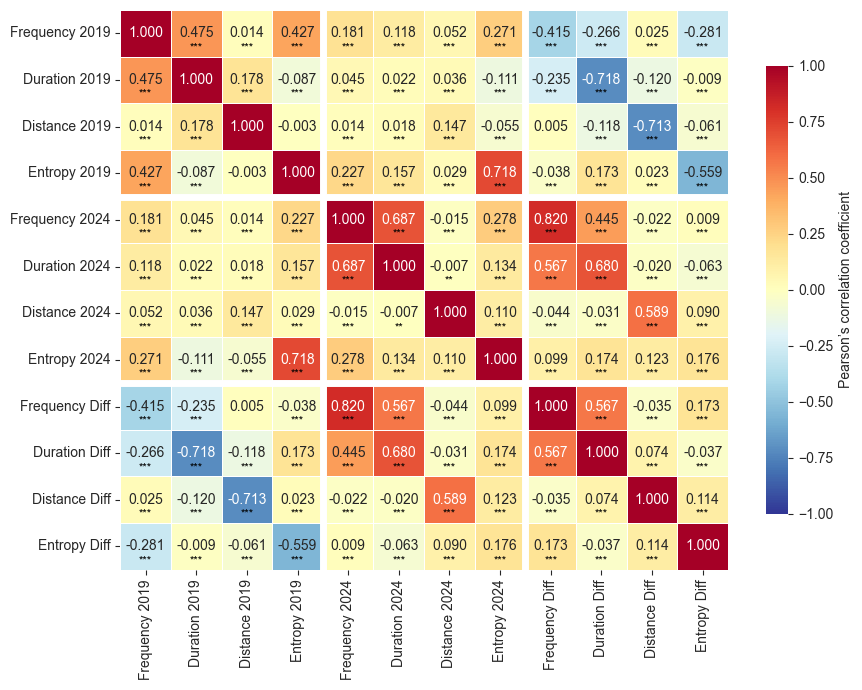

In [23]:


all_columns = [
    'avg_fre19', 'avg_time19', 'avg_dis19', 'entropy19',
    'avg_fre24', 'avg_time24', 'avg_dis24', 'entropy24',
    'avg_fre_diff', 'avg_time_diff', 'avg_dis_diff', 'entropy_diff'
]

a = visit_fre_diff.loc[:, ].merge(visit_time_diff.loc[:,], on=group_list + [ses]).merge(visit_dis_diff.loc[:,], on=group_list + [ses]).merge(visit_ent_diff.loc[:,],  on=group_list + [ses])

data = a[all_columns]
corr_matrix = pd.DataFrame(np.zeros((len(all_columns), len(all_columns))), 
                          columns=all_columns, index=all_columns)
p_matrix = pd.DataFrame(np.zeros((len(all_columns), len(all_columns))), 
                       columns=all_columns, index=all_columns)

for i in range(len(all_columns)):
    for j in range(len(all_columns)):
        corr, p_val = pearsonr(data[all_columns[i]], data[all_columns[j]])
        corr_matrix.iloc[i, j] = corr
        p_matrix.iloc[i, j] = p_val

plt.figure(figsize=(9, 7))

group_labels = ['Frequency', 'Duration', 'Distance', 'Entropy']
year_labels = ['2019', '2024', 'Diff']

custom_labels = []
for year in year_labels:
    for group in group_labels:
        if year != 'Diff':
            custom_labels.append(f"{group} {year}")
        else:
            custom_labels.append(f"{group} Diff")

sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".3f", 
    cmap='RdYlBu_r',
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Pearson’s correlation coefficient"},
    xticklabels=custom_labels,
    yticklabels=custom_labels
)

for i in range(len(all_columns)):
    for j in range(len(all_columns)):
        if i != j:
            p_val = p_matrix.iloc[i, j]
            if p_val < 0.001:
                marker = "***"
            elif p_val < 0.01:
                marker = "**"
            elif p_val < 0.05:
                marker = "*"
            else:
                marker = ""
            plt.text(j + 0.5, i + 0.8, marker, 
                    ha='center', va='center', color='black', fontsize=8)

plt.axvline(4, color='white', lw=5)
plt.axhline(4, color='white', lw=5)
plt.axvline(8, color='white', lw=5) 
plt.axhline(8, color='white', lw=5)

plt.tight_layout()
# plt.savefig('.png', dpi=500, bbox_inches='tight')
plt.show()

In [24]:
warnings.filterwarnings('ignore')

group_list = ['home_grid','age','gender','is_local']
ses = 'ses'
def cal_visit_diff(data19, data24, kind):
    visit_diff = data19.loc[:, group_list + [ses, kind]].merge(data24.loc[:, group_list + [ses, kind]], on=group_list + [ses], suffixes=('19', '24'))
    visit_diff[kind + '_diff'] = visit_diff[kind + '24'] - visit_diff[kind + '19']
    return visit_diff

visit_fre_diff = cal_visit_diff(visit_fre1903, visit_fre2403, 'avg_fre')
visit_time_diff = cal_visit_diff(visit_time1903, visit_time2403, 'avg_time')
visit_dis_diff = cal_visit_diff(visit_dis1903, visit_dis2403, 'avg_dis')
visit_ent_diff = cal_visit_diff(visit_ent1903, visit_ent2403, 'entropy')

visit_diff = visit_fre_diff.loc[:, group_list + [ses, 'avg_fre_diff']].merge(visit_time_diff.loc[:, group_list + [ses, 'avg_time_diff']], on=group_list + [ses]).merge(visit_dis_diff.loc[:, group_list + [ses, 'avg_dis_diff']], on=group_list + [ses]).merge(visit_ent_diff.loc[:, group_list + [ses, 'entropy_diff']],  on=group_list + [ses])

ses_bins = [1, 26, 51, 76, 101]
ses_labels = ['low ses', 'lower middle ses', 'upper middle ses', 'high ses']
visit_diff['ses_group'] = pd.cut(visit_diff['ses'], bins=ses_bins, labels=ses_labels, right=False, include_lowest=False)

visit_diff_young = visit_diff.loc[visit_diff['age'].isin(['a1', 'a2', 'a3'])]
visit_diff_mid = visit_diff.loc[visit_diff['age'].isin(['a4', 'a5'])]
visit_diff_old = visit_diff.loc[visit_diff['age'].isin(['a6', 'a7'])]

scaler = StandardScaler()
visit_diff[['avg_fre_diff', 'avg_time_diff', 'avg_dis_diff', 'entropy_diff']] = \
    scaler.fit_transform(visit_diff[['avg_fre_diff', 'avg_time_diff', 'avg_dis_diff', 'entropy_diff']])

def get_regression_stats(group, x, y):
    if len(group) < 5:
        return pd.Series({
            'Slope': np.nan,
            'CI_lower': np.nan,
            'CI_upper': np.nan,
            'P_value': np.nan
        })
    
    X = sm.add_constant(group[x])
    model = sm.OLS(group[y], X).fit()
    conf_int = model.conf_int(alpha=0.05).iloc[1]
    return pd.Series({
        'Slope': model.params.iloc[1],
        'CI_lower': conf_int[0],
        'CI_upper': conf_int[1],
        'P_value': model.pvalues.iloc[1]
    })

all_results = []

for x, y in [('avg_fre_diff', 'avg_time_diff'), 
             ('avg_fre_diff', 'avg_dis_diff'),
             ('avg_fre_diff', 'entropy_diff')]:
    
    print(f"\n=== Model: {y} ~ {x} ===")
    model_results = []
    
    for age_label, age_group in zip(['Young', 'Middle', 'Old'], 
                                   [['a1','a2','a3'], ['a4','a5'], ['a6','a7']]):
        group_data = visit_diff[visit_diff['age'].isin(age_group)]
        res = group_data.groupby('ses_group', observed=True).apply(get_regression_stats, x=x, y=y).reset_index()
        res['age_group'] = age_label
        res['model'] = f"{y}~{x}"
        model_results.append(res)
        all_results.extend(res.to_dict('records'))
    
    combined = pd.concat(model_results).dropna()
    
    # Print summary table for this model
    print("\nAge Group | SES Group       | Coefficient | 95% CI Lower | 95% CI Upper | P-value")
    print("------------------------------------------------------------------------------")
    for _, row in combined.iterrows():
        print(f"{row['age_group']:9} | {row['ses_group']:15} | {row['Slope']:10.4f} | {row['CI_lower']:12.4f} | {row['CI_upper']:12.4f} | {row['P_value']:.4f}")


=== Model: avg_time_diff ~ avg_fre_diff ===

Age Group | SES Group       | Coefficient | 95% CI Lower | 95% CI Upper | P-value
------------------------------------------------------------------------------
Young     | low ses         |     0.4948 |       0.4829 |       0.5067 | 0.0000
Young     | lower middle ses |     0.5323 |       0.5191 |       0.5455 | 0.0000
Young     | upper middle ses |     0.5651 |       0.5519 |       0.5783 | 0.0000
Young     | high ses        |     0.5965 |       0.5830 |       0.6101 | 0.0000
Middle    | low ses         |     0.5177 |       0.5027 |       0.5327 | 0.0000
Middle    | lower middle ses |     0.6130 |       0.5957 |       0.6303 | 0.0000
Middle    | upper middle ses |     0.6705 |       0.6537 |       0.6872 | 0.0000
Middle    | high ses        |     0.6692 |       0.6526 |       0.6858 | 0.0000
Old       | low ses         |     0.5324 |       0.5167 |       0.5481 | 0.0000
Old       | lower middle ses |     0.5799 |       0.5609 |       0.59

In [25]:

group_list = ['home_grid','age','gender','is_local']
ses = 'ses'
def cal_visit_diff(data19, data24, kind):
    visit_diff = data19.loc[:, group_list + [ses, kind]].merge(
        data24.loc[:, group_list + [ses, kind]], 
        on=group_list + [ses], 
        suffixes=('19', '24')
    )
    visit_diff[kind + '_diff'] = visit_diff[kind + '24'] - visit_diff[kind + '19']
    return visit_diff

visit_fre_diff = cal_visit_diff(visit_fre1903, visit_fre2403, 'avg_fre')
visit_time_diff = cal_visit_diff(visit_time1903, visit_time2403, 'avg_time')
visit_dis_diff = cal_visit_diff(visit_dis1903, visit_dis2403, 'avg_dis')
visit_ent_diff = cal_visit_diff(visit_ent1903, visit_ent2403, 'entropy')

visit_diff = visit_fre_diff.loc[:, group_list + [ses, 'avg_fre_diff']]\
    .merge(visit_time_diff.loc[:, group_list + [ses, 'avg_time_diff']], on=group_list + [ses])\
    .merge(visit_dis_diff.loc[:, group_list + [ses, 'avg_dis_diff']], on=group_list + [ses])\
    .merge(visit_ent_diff.loc[:, group_list + [ses, 'entropy_diff']], on=group_list + [ses])

ses_bins = [1, 26, 51, 76, 101]
ses_labels = ['low ses', 'lower middle ses', 'upper middle ses', 'high ses']
visit_diff['ses_group'] = pd.cut(
    visit_diff['ses'], 
    bins=ses_bins, 
    labels=ses_labels, 
    right=False
)

scaler = StandardScaler()
visit_diff[['avg_fre_diff', 'avg_time_diff', 'avg_dis_diff', 'entropy_diff']] = \
    scaler.fit_transform(visit_diff[['avg_fre_diff', 'avg_time_diff', 'avg_dis_diff', 'entropy_diff']])

local_categories = ['Y', 'N']
local_labels = ['Local', 'Migrant']

def get_regression_stats(group, x, y):
    if len(group) < 10: 
        return pd.Series({
            'Slope': np.nan,
            'CI_lower': np.nan,
            'CI_upper': np.nan,
            'P_value': np.nan
        })
    
    X = sm.add_constant(group[x])
    model = sm.OLS(group[y], X).fit()
    conf_int = model.conf_int(alpha=0.05).iloc[1]
    return pd.Series({
        'Slope': model.params.iloc[1],
        'CI_lower': conf_int[0],
        'CI_upper': conf_int[1],
        'P_value': model.pvalues.iloc[1]
    })

all_results = []

for x, y in [('avg_fre_diff', 'avg_time_diff'), 
             ('avg_fre_diff', 'avg_dis_diff'),
             ('avg_fre_diff', 'entropy_diff')]:
    
    print(f"\n=== Model: {y} ~ {x} ===")
    model_results = []
    
    for local_code, local_label in zip(local_categories, local_labels):
        group_data = visit_diff[visit_diff['is_local'] == local_code]
        res = group_data.groupby('ses_group', observed=True).apply(get_regression_stats, x=x, y=y).reset_index()
        res['local_group'] = local_label
        res['model'] = f"{y}~{x}"
        model_results.append(res)
        all_results.extend(res.to_dict('records'))
    
    combined = pd.concat(model_results).dropna()
    
    # Print summary table for this model
    print("\nGroup     | SES Group       | Coefficient | 95% CI Lower | 95% CI Upper | P-value")
    print("------------------------------------------------------------------------------")
    for _, row in combined.iterrows():
        print(f"{row['local_group']:7} | {row['ses_group']:15} | {row['Slope']:10.4f} | {row['CI_lower']:12.4f} | {row['CI_upper']:12.4f} | {row['P_value']:.4f}")


=== Model: avg_time_diff ~ avg_fre_diff ===

Group     | SES Group       | Coefficient | 95% CI Lower | 95% CI Upper | P-value
------------------------------------------------------------------------------
Local   | low ses         |     0.4685 |       0.4623 |       0.4746 | 0.0000
Local   | lower middle ses |     0.5448 |       0.5371 |       0.5524 | 0.0000
Local   | upper middle ses |     0.6179 |       0.6099 |       0.6260 | 0.0000
Local   | high ses        |     0.6423 |       0.6345 |       0.6500 | 0.0000
Migrant | low ses         |     0.5784 |       0.5631 |       0.5938 | 0.0000
Migrant | lower middle ses |     0.5859 |       0.5698 |       0.6019 | 0.0000
Migrant | upper middle ses |     0.6030 |       0.5873 |       0.6186 | 0.0000
Migrant | high ses        |     0.6325 |       0.6164 |       0.6486 | 0.0000

=== Model: avg_dis_diff ~ avg_fre_diff ===

Group     | SES Group       | Coefficient | 95% CI Lower | 95% CI Upper | P-value
--------------------------------------

In [26]:
group_list = ['home_grid','age','gender','is_local']
ses = 'ses'
def cal_visit_diff(data19, data24, kind):
    visit_diff = data19.loc[:, group_list + [ses, kind]].merge(
        data24.loc[:, group_list + [ses, kind]], 
        on=group_list + [ses], 
        suffixes=('19', '24')
    )
    visit_diff[kind + '_diff'] = visit_diff[kind + '24'] - visit_diff[kind + '19']
    return visit_diff

visit_fre_diff = cal_visit_diff(visit_fre1903, visit_fre2403, 'avg_fre')
visit_time_diff = cal_visit_diff(visit_time1903, visit_time2403, 'avg_time')
visit_dis_diff = cal_visit_diff(visit_dis1903, visit_dis2403, 'avg_dis')
visit_ent_diff = cal_visit_diff(visit_ent1903, visit_ent2403, 'entropy')

visit_diff = visit_fre_diff.loc[:, group_list + [ses, 'avg_fre_diff']]\
    .merge(visit_time_diff.loc[:, group_list + [ses, 'avg_time_diff']], on=group_list + [ses])\
    .merge(visit_dis_diff.loc[:, group_list + [ses, 'avg_dis_diff']], on=group_list + [ses])\
    .merge(visit_ent_diff.loc[:, group_list + [ses, 'entropy_diff']], on=group_list + [ses])

ses_bins = [1, 26, 51, 76, 101]
ses_labels = ['low ses', 'lower middle ses', 'upper middle ses', 'high ses']
visit_diff['ses_group'] = pd.cut(
    visit_diff['ses'], 
    bins=ses_bins, 
    labels=ses_labels, 
    right=False
)

scaler = StandardScaler()
visit_diff[['avg_fre_diff', 'avg_time_diff', 'avg_dis_diff', 'entropy_diff']] = \
    scaler.fit_transform(visit_diff[['avg_fre_diff', 'avg_time_diff', 'avg_dis_diff', 'entropy_diff']])

local_categories = [1, 2]
local_labels = ['Male', 'Female']

def get_regression_stats(group, x, y):
    if len(group) < 10: 
        return pd.Series({
            'Slope': np.nan,
            'CI_lower': np.nan,
            'CI_upper': np.nan,
            'P_value': np.nan
        })
    
    X = sm.add_constant(group[x])
    model = sm.OLS(group[y], X).fit()
    conf_int = model.conf_int(alpha=0.05).iloc[1]
    return pd.Series({
        'Slope': model.params.iloc[1],
        'CI_lower': conf_int[0],
        'CI_upper': conf_int[1],
        'P_value': model.pvalues.iloc[1]
    })

all_results = []

for x, y in [('avg_fre_diff', 'avg_time_diff'), 
             ('avg_fre_diff', 'avg_dis_diff'),
             ('avg_fre_diff', 'entropy_diff')]:
    
    print(f"\n=== Model: {y} ~ {x} ===")
    model_results = []
    
    for local_code, local_label in zip(local_categories, local_labels):
        group_data = visit_diff[visit_diff['gender'] == local_code]
        res = group_data.groupby('ses_group', observed=True).apply(get_regression_stats, x=x, y=y).reset_index()
        res['local_group'] = local_label
        res['model'] = f"{y}~{x}"
        model_results.append(res)
        all_results.extend(res.to_dict('records'))
    
    combined = pd.concat(model_results).dropna()
    
    # Print summary table for this model
    print("\nGroup     | SES Group       | Coefficient | 95% CI Lower | 95% CI Upper | P-value")
    print("------------------------------------------------------------------------------")
    for _, row in combined.iterrows():
        print(f"{row['local_group']:7} | {row['ses_group']:15} | {row['Slope']:10.4f} | {row['CI_lower']:12.4f} | {row['CI_upper']:12.4f} | {row['P_value']:.4f}")


=== Model: avg_time_diff ~ avg_fre_diff ===

Group     | SES Group       | Coefficient | 95% CI Lower | 95% CI Upper | P-value
------------------------------------------------------------------------------
Male    | low ses         |     0.5048 |       0.4937 |       0.5159 | 0.0000
Male    | lower middle ses |     0.5446 |       0.5324 |       0.5567 | 0.0000
Male    | upper middle ses |     0.5714 |       0.5596 |       0.5833 | 0.0000
Male    | high ses        |     0.6298 |       0.6172 |       0.6424 | 0.0000
Female  | low ses         |     0.5004 |       0.4890 |       0.5118 | 0.0000
Female  | lower middle ses |     0.5737 |       0.5600 |       0.5874 | 0.0000
Female  | upper middle ses |     0.6451 |       0.6311 |       0.6592 | 0.0000
Female  | high ses        |     0.6292 |       0.6155 |       0.6430 | 0.0000

=== Model: avg_dis_diff ~ avg_fre_diff ===

Group     | SES Group       | Coefficient | 95% CI Lower | 95% CI Upper | P-value
--------------------------------------

In [27]:
group_col = ['home_grid', 'ses', 'age', 'gender', 'is_local']
ses_labels = ['low ses', 'lower middle ses', 'upper middle ses', 'high ses']

visit_grid_iso = pd.read_csv(os.path.join(root, 'data', 'visit_grid_iso.csv'))
visit_grid_ses = pd.read_csv(os.path.join(root, 'data', 'visit_grid_ses.csv'))

def analyze_year(year):
    iso_col = f'isolation_{year}'
    ses_col = f'avg_ses_{year}'
    df = (data_prepross(globals()[f'od{year}'])
          .merge(od_line_geo, on=['home_grid', 'visit_grid'])
          .assign(distance_km=lambda x: x['distance'] / 1000)
          .query(f"ptype == 0 & distance_km > 0.36")) # visit
    def categorize_ses(ses_value):
        if 1 <= ses_value <= 25:
            return 'low ses'
        elif 26 <= ses_value <= 50:
            return 'lower middle ses'
        elif 51 <= ses_value <= 75:
            return 'upper middle ses'
        elif 76 <= ses_value <= 100:
            return 'high ses'
        else:
            return np.nan
    df_merge = (df.merge(visit_grid_iso.loc[:, ['visit_grid', iso_col]])
                .merge(visit_grid_ses.loc[:, ['visit_grid', ses_col]])
                .assign(ses_group=lambda x: x[ses_col].apply(categorize_ses))
                .dropna(subset=['ses_group']))
    max_distance_km = df_merge['distance_km'].max()
    distance_bins = np.linspace(0.36, max_distance_km, 10)
    distance_labels = [f"{b:.1f}km" for b in distance_bins[:-1]]
    df_merge['distance_bin'] = pd.cut(df_merge['distance_km'],
                                    bins=distance_bins,
                                    labels=distance_labels)
    result = (
        df_merge.groupby(['ses_group', 'distance_bin'], observed=True)
        .apply(
            lambda g: pd.Series({
                'weighted_avg_isolation': np.average(g[iso_col], weights=g['sum_time']),
                'weighted_avg_ses': np.average(g[ses_col], weights=g['sum_time']),
                'total_time': g['sum_time'].sum(),
                'year': year
            })
        )
        .reset_index()
    )
    group_total_time = result.groupby('ses_group')['total_time'].transform('sum')
    result['visit_probability'] = result['total_time'] / group_total_time
    result['distance_mid'] = result['distance_bin'].apply(
        lambda x: (distance_bins[distance_labels.index(x)] + distance_bins[distance_labels.index(x)+1])/2
    )
    return result

results = []
for year in ['1903', '2403']:
    results.append(analyze_year(year))
combined = pd.concat(results)

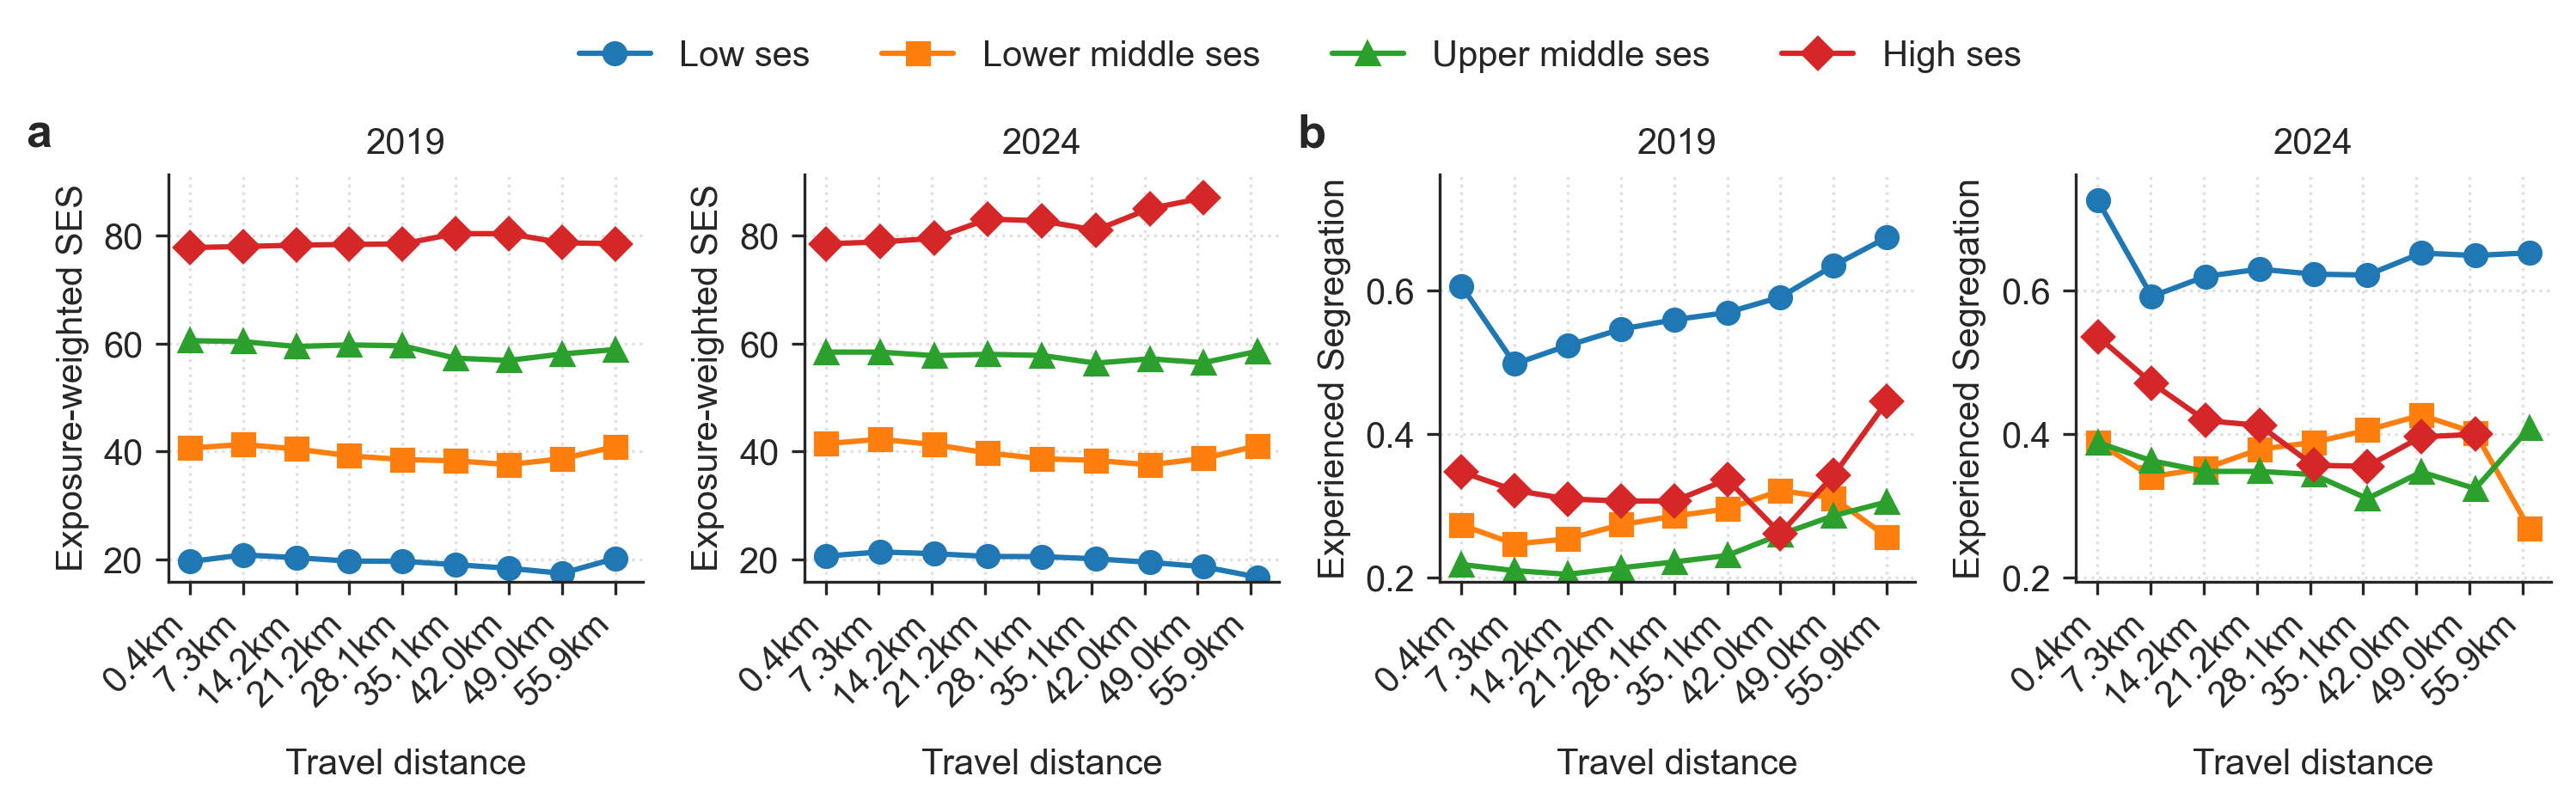

In [29]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3), dpi=300, sharex=True)
axes = axes.flatten()
plt.subplots_adjust(wspace=0.35)
markers = ['o', 's', '^', 'D']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

ses_min = combined['weighted_avg_ses'].min() * 0.95
ses_max = combined['weighted_avg_ses'].max() * 1.05
iso_min = combined['weighted_avg_isolation'].min() * 0.95
iso_max = combined['weighted_avg_isolation'].max() * 1.05

for i, year in enumerate(['1903', '2403']):
    year_data = combined[combined['year'] == year]
    for j, ses_group in enumerate(ses_labels):
        subset = year_data[year_data['ses_group'] == ses_group]
        axes[i].plot(subset['distance_mid'],
                   subset['weighted_avg_ses'],
                   marker=markers[j],
                   markersize=6,
                   linewidth=1.5,
                   color=colors[j],
                   label=ses_group.capitalize())
    axes[i].set_ylabel('Exposure-weighted SES', fontsize=10)
    axes[i].set_ylim(ses_min, ses_max)
    axes[i].grid(True, linestyle=':', alpha=0.6)

for i, year in enumerate(['1903', '2403']):
    year_data = combined[combined['year'] == year]
    for j, ses_group in enumerate(ses_labels):
        subset = year_data[year_data['ses_group'] == ses_group]
        axes[i+2].plot(subset['distance_mid'],
                      subset['weighted_avg_isolation'],
                      marker=markers[j],
                      markersize=6,
                      linewidth=1.5,
                      color=colors[j],
                      label=ses_group.capitalize())
    axes[i+2].set_ylabel('Experienced Segregation', fontsize=10)
    axes[i+2].set_ylim(iso_min, iso_max)
    axes[i+2].grid(True, linestyle=':', alpha=0.6)

for ax in axes:
    ax.set_xlabel('Travel distance', fontsize=10, labelpad=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=10)
    first_year_data = combined[combined['year'] == '1903']
    distance_mids = first_year_data['distance_mid'].unique()
    distance_bins = first_year_data['distance_bin'].unique()
    ax.set_xticks(distance_mids)
    ax.set_xticklabels(distance_bins, rotation=45, ha='right', fontsize=10)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 1.05),
           ncol=4, 
           frameon=False, 
           fontsize=10)

axes[0].set_title('2019', fontsize=10)
axes[1].set_title('2024', fontsize=10)
axes[2].set_title('2019', fontsize=10)
axes[3].set_title('2024', fontsize=10)
axes[0].text(-0.3, 1.15, 'a', transform=axes[0].transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
axes[2].text(-0.3, 1.15, 'b', transform=axes[2].transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
plt.tight_layout()
# plt.savefig('(visit).png', dpi=500, bbox_inches='tight')
plt.show()

In [30]:
group_col = ['home_grid', 'ses', 'age', 'gender', 'is_local']
ses_labels = ['low ses', 'lower middle ses', 'upper middle ses', 'high ses']

visit_grid_iso = pd.read_csv(os.path.join(root, 'data', 'visit_grid_iso.csv'))
visit_grid_ses = pd.read_csv(os.path.join(root, 'data', 'visit_grid_ses.csv'))

def analyze_year(year):
    iso_col = f'isolation_{year}'
    ses_col = f'avg_ses_{year}'
    df = (data_prepross(globals()[f'od{year}'])
          .merge(od_line_geo, on=['home_grid', 'visit_grid'])
          .assign(distance_km=lambda x: x['distance'] / 1000)
          .query(f"ptype == 2 & distance_km > 0.36")) # work
    def categorize_ses(ses_value):
        if 1 <= ses_value <= 25:
            return 'low ses'
        elif 26 <= ses_value <= 50:
            return 'lower middle ses'
        elif 51 <= ses_value <= 75:
            return 'upper middle ses'
        elif 76 <= ses_value <= 100:
            return 'high ses'
        else:
            return np.nan
    df_merge = (df.merge(visit_grid_iso.loc[:, ['visit_grid', iso_col]])
                .merge(visit_grid_ses.loc[:, ['visit_grid', ses_col]])
                .assign(ses_group=lambda x: x[ses_col].apply(categorize_ses))
                .dropna(subset=['ses_group']))
    max_distance_km = df_merge['distance_km'].max()
    distance_bins = np.linspace(0.36, max_distance_km, 10)
    distance_labels = [f"{b:.1f}km" for b in distance_bins[:-1]]
    df_merge['distance_bin'] = pd.cut(df_merge['distance_km'],
                                    bins=distance_bins,
                                    labels=distance_labels)
    result = (
        df_merge.groupby(['ses_group', 'distance_bin'], observed=True)
        .apply(
            lambda g: pd.Series({
                'weighted_avg_isolation': np.average(g[iso_col], weights=g['sum_time']),
                'weighted_avg_ses': np.average(g[ses_col], weights=g['sum_time']),
                'total_time': g['sum_time'].sum(),
                'year': year
            })
        )
        .reset_index()
    )
    group_total_time = result.groupby('ses_group')['total_time'].transform('sum')
    result['visit_probability'] = result['total_time'] / group_total_time
    result['distance_mid'] = result['distance_bin'].apply(
        lambda x: (distance_bins[distance_labels.index(x)] + distance_bins[distance_labels.index(x)+1])/2
    )
    return result

results = []
for year in ['1903', '2403']:
    results.append(analyze_year(year))
combined = pd.concat(results)

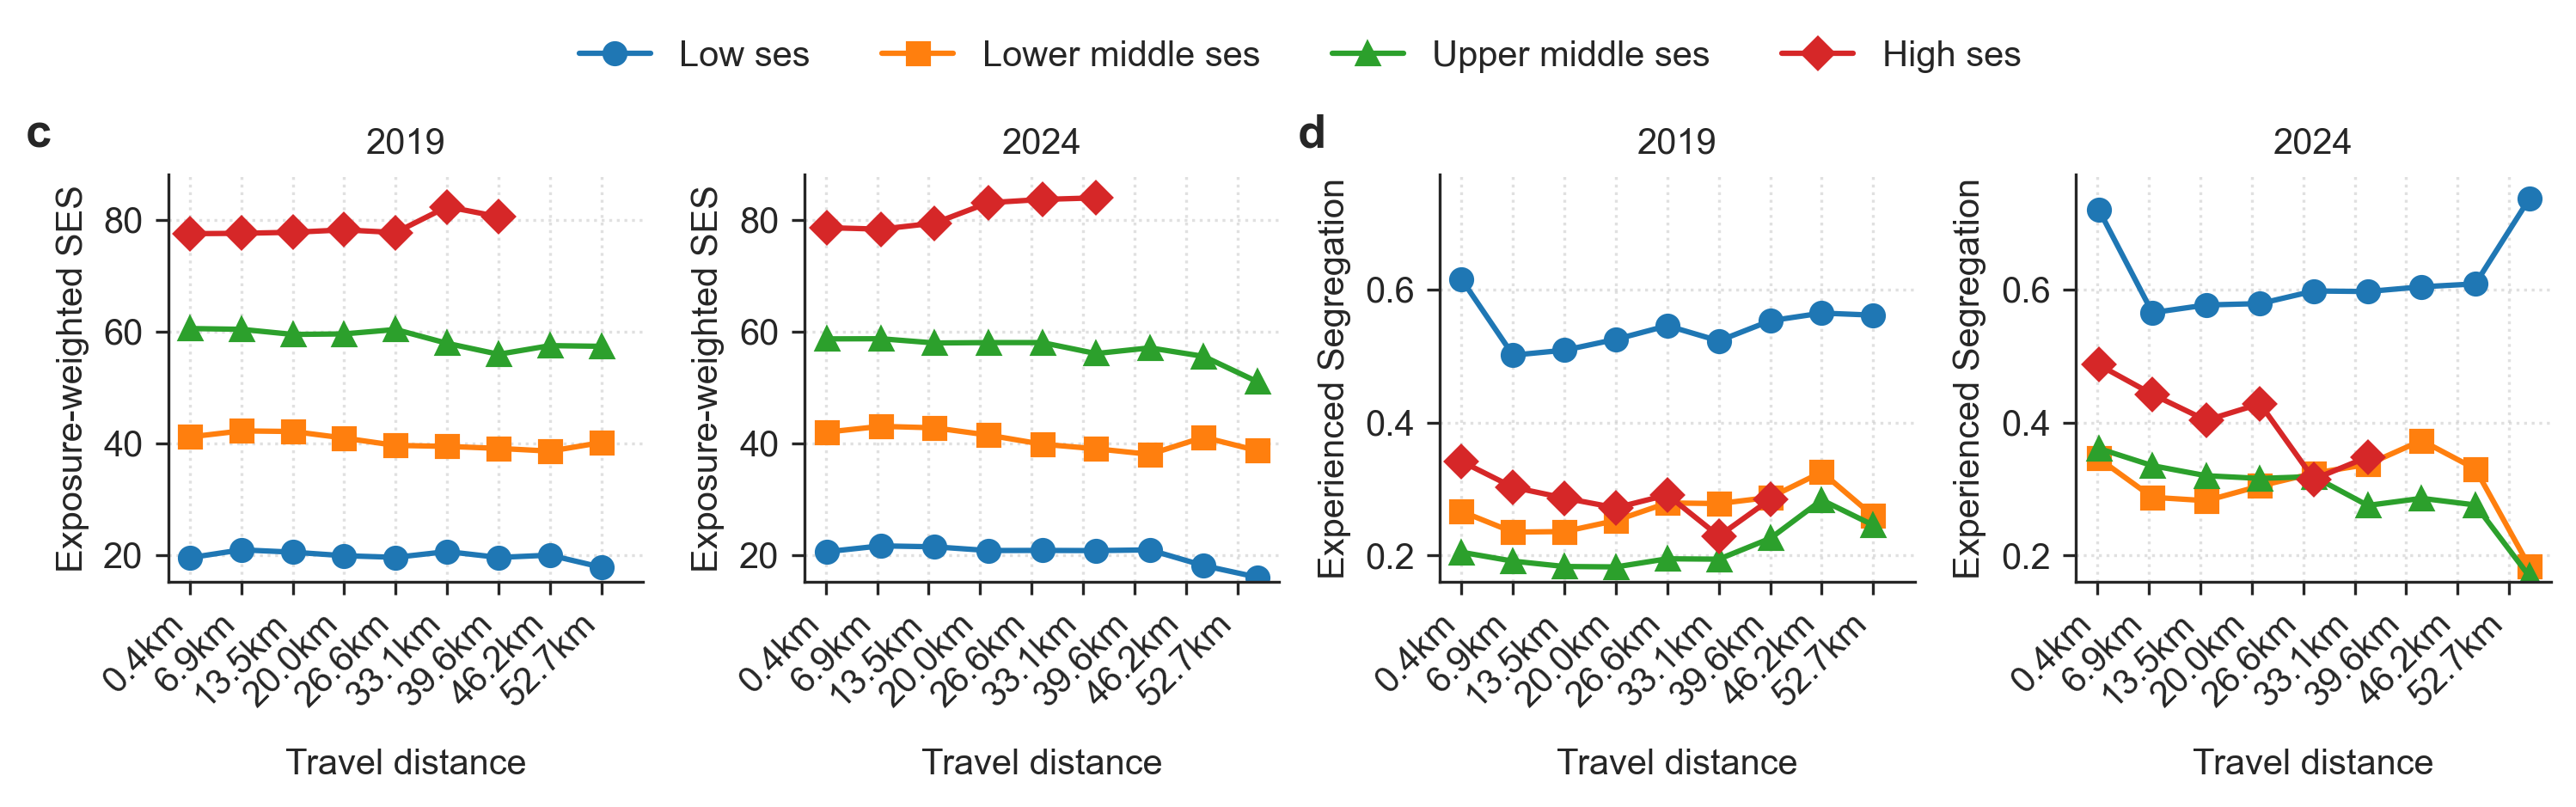

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3), dpi=300, sharex=True)
axes = axes.flatten()
plt.subplots_adjust(wspace=0.35)
markers = ['o', 's', '^', 'D']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

ses_min = combined['weighted_avg_ses'].min() * 0.95
ses_max = combined['weighted_avg_ses'].max() * 1.05
iso_min = combined['weighted_avg_isolation'].min() * 0.95
iso_max = combined['weighted_avg_isolation'].max() * 1.05

for i, year in enumerate(['1903', '2403']):
    year_data = combined[combined['year'] == year]
    for j, ses_group in enumerate(ses_labels):
        subset = year_data[year_data['ses_group'] == ses_group]
        axes[i].plot(subset['distance_mid'],
                   subset['weighted_avg_ses'],
                   marker=markers[j],
                   markersize=6,
                   linewidth=1.5,
                   color=colors[j],
                   label=ses_group.capitalize())
    axes[i].set_ylabel('Exposure-weighted SES', fontsize=10)
    axes[i].set_ylim(ses_min, ses_max)
    axes[i].grid(True, linestyle=':', alpha=0.6)

for i, year in enumerate(['1903', '2403']):
    year_data = combined[combined['year'] == year]
    for j, ses_group in enumerate(ses_labels):
        subset = year_data[year_data['ses_group'] == ses_group]
        axes[i+2].plot(subset['distance_mid'],
                      subset['weighted_avg_isolation'],
                      marker=markers[j],
                      markersize=6,
                      linewidth=1.5,
                      color=colors[j],
                      label=ses_group.capitalize())
    axes[i+2].set_ylabel('Experienced Segregation', fontsize=10)
    axes[i+2].set_ylim(iso_min, iso_max)
    axes[i+2].grid(True, linestyle=':', alpha=0.6)

for ax in axes:
    ax.set_xlabel('Travel distance', fontsize=10, labelpad=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=10)
    first_year_data = combined[combined['year'] == '1903']
    distance_mids = first_year_data['distance_mid'].unique()
    distance_bins = first_year_data['distance_bin'].unique()
    ax.set_xticks(distance_mids)
    ax.set_xticklabels(distance_bins, rotation=45, ha='right', fontsize=10)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.05),
           ncol=4,
           frameon=False,
           fontsize=10)

axes[0].set_title('2019', fontsize=10)
axes[1].set_title('2024', fontsize=10)
axes[2].set_title('2019', fontsize=10)
axes[3].set_title('2024', fontsize=10)
axes[0].text(-0.3, 1.15, 'c', transform=axes[0].transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
axes[2].text(-0.3, 1.15, 'd', transform=axes[2].transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
plt.tight_layout()
# plt.savefig('(work).png', dpi=500, bbox_inches='tight')
plt.show()